# Predict Density of Covid 19 Cases
Main goal is to predict case density, which is the number of cases per unit of population of a given county. We initially consider all cases from the *Covid Act Now* data, March 2020 to present, but we might look at smaller blocks of time.  
Initial features...  
- `density` (population density)
- `area`
- `neighbor_density` (mean population density of neighboring counties)
- `vaccination_rate` (maximum vaccination rate ever reported for the county)
- `case_peak_ratio`  
As described in the exploration notebook, `case-peak-ratio` is the ratio of peak monthly case counts before 2020-09 to after 2020-09, inspired by the (author's) notion that a higher ratio indicates a county's willingness to adopt lifestyle changes to reduce disease transmission.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

%matplotlib inline

In [2]:
# Data was largely processed in the exploration notebook
# Note: Need to actually derive a couple of those values
# Also note: the index of the counties geodataframe is FIPS, which is an gov't issues unique identifer for each US county
counties = pd.read_pickle('../../pickles/CANpickles/cancounties.pkl')
features = ['density', 'area', 'neighbor_density', 'vaccination_rate', 'case_peak_ratio', 'case_total_ratio']
label='case_density'

## Add Initial Derived Columns

In [3]:
counties['case_density'] = counties['cases'] / counties['pop']

In [4]:
# Empty case_densities?
counties['case_density'].isna().sum()

# This is consistent with the fact that we do not have case counts on 102 counties from exploration notebook

102

In [5]:
def neighbor_density_mean(neighbors):
    if len(neighbors) == 0:
        return 0.0
    else:
        return sum([counties.loc[fips, 'density'] for fips in neighbors])/len(neighbors)

counties['neighbor_density'] = counties['neighbors'].map(neighbor_density_mean)

In [6]:
# Sanity check #1, we know there are 3 island counties that share no border with another county and, thus, have a neighbor_density of zero
counties[counties['neighbor_density']==0.0]

# Checks out, good.

,state_name,county_name,area,geometry,pop,density,neighbors,cases,deaths,vaccination_rate,infection_rate,case_peak_ratio,cases_w1_w2,cases_w3,cases_w4,case_total_ratio,case_density,neighbor_density
FIPS,,,,,,,,,,,,,,,,,,
53055,Washington,San Juan,450432205,"MULTIPOLYGON (((-122.76657 48.70780, -122.7656...",17582,39.033621,[],256.0,0.0,0.718,NaN,0.206349,34.0,174.0,74.0,0.195402,0.014560,0.0
25007,Massachusetts,Dukes,267292993,"MULTIPOLYGON (((-70.80710 41.45858, -70.80258 ...",17332,64.842702,[],1688.0,2.0,NaN,0.79,0.073955,77.0,1354.0,284.0,0.056869,0.097392,0.0
25019,Massachusetts,Nantucket,119637319,"MULTIPOLYGON (((-70.23405 41.28565, -70.22122 ...",11399,95.279634,[],1851.0,3.0,NaN,0.42,0.156250,48.0,1449.0,333.0,0.033126,0.162383,0.0


In [7]:
# Sanity check #2, pull up Albemarle County, VA, observe its neighbor_density
counties[counties['county_name']=='Albemarle']

,state_name,county_name,area,geometry,pop,density,neighbors,cases,deaths,vaccination_rate,infection_rate,case_peak_ratio,cases_w1_w2,cases_w3,cases_w4,case_total_ratio,case_density,neighbor_density
FIPS,,,,,,,,,,,,,,,,,,
51003,Virginia,Albemarle,1866014147,"POLYGON ((-78.83701 38.04826, -78.82993 38.054...",109330,58.590124,"[51165, 51125, 51029, 51015, 51137, 51109, 510...",6533.0,85.0,0.648,1.26,0.267921,1005.0,4770.0,746.0,0.210692,0.059755,225.484953


<AxesSubplot:>

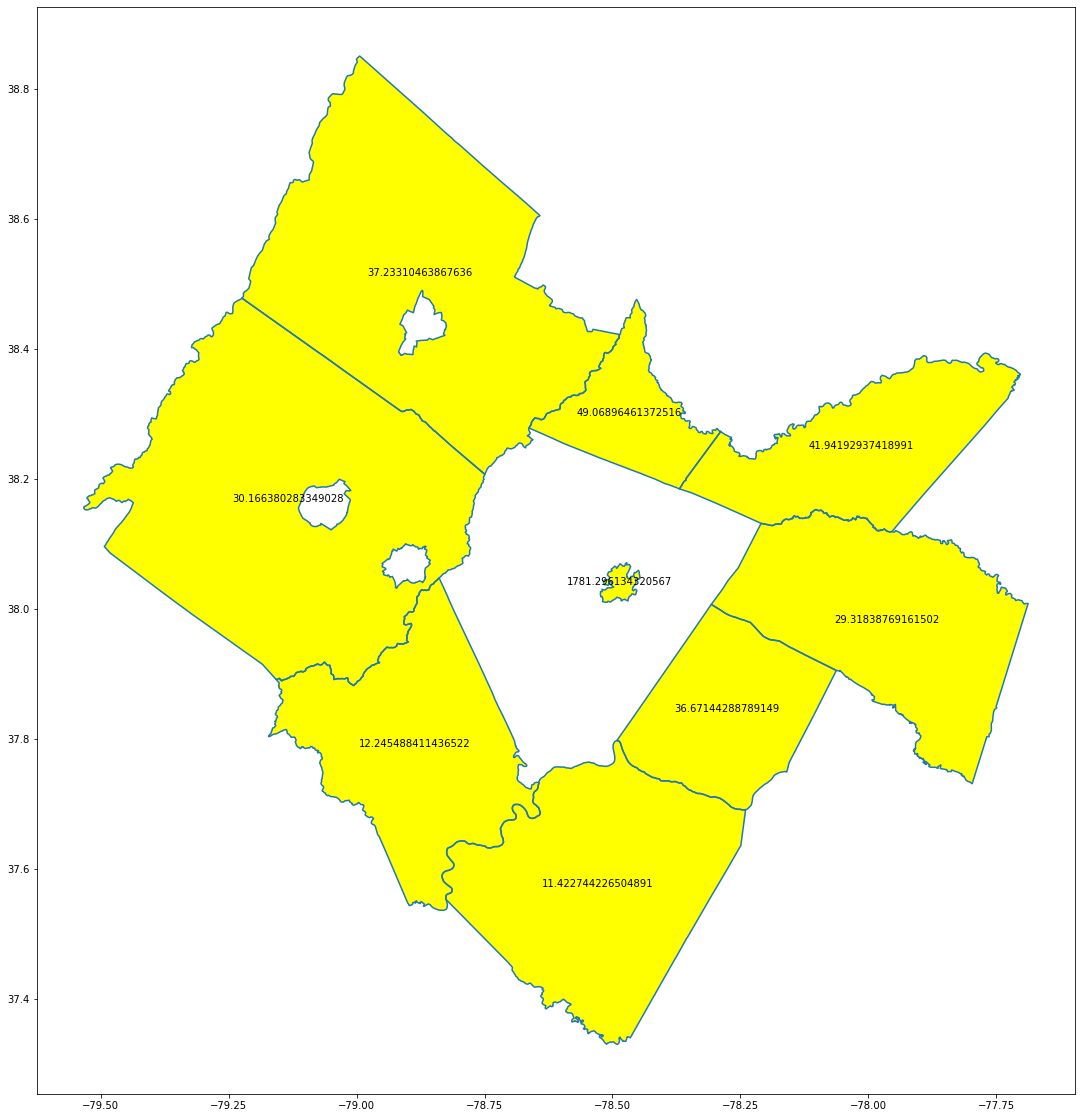

In [8]:
# ...then pull up Albemarle County's neighbors (yellow shapes) and their population densities
# Then manually calculate Albemarle's avg neighbor density
albemarle_surround = counties[counties.index.isin(counties.loc[counties['county_name']=='Albemarle', 'neighbors'][0].tolist())]
base = albemarle_surround.boundary.plot(figsize=(20,20))
albemarle_surround.apply(lambda x: base.annotate(text=x['density'], xy=x['geometry'].centroid.coords[0], ha='center'), axis=1)
albemarle_surround.plot(color='yellow', ax=base)

# Pull out the calculator --> 225.48, checks out
# Note Virginia's prolific number of independent cities
# The small yellow shape in the center of Albemarle County (which is the white county) is the city of Charlottesville
# The small white areas in the neighboring western counties are the cities of Waynesboro, Stauntan, and Harrisonburg
# Neighboring county density does not include the neighboring counties' independent city populations, which is a small problem
# POSSIBLE FUTURE REFINDEMENT, FIX THIS

## Process Initial Data

In [9]:
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3108 entries, 21141 to 35037
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   state_name        3108 non-null   object  
 1   county_name       3108 non-null   object  
 2   area              3108 non-null   int64   
 3   geometry          3108 non-null   geometry
 4   pop               3108 non-null   int64   
 5   density           3108 non-null   float64 
 6   neighbors         3108 non-null   object  
 7   cases             3006 non-null   float64 
 8   deaths            3006 non-null   float64 
 9   vaccination_rate  3001 non-null   float64 
 10  infection_rate    2835 non-null   float64 
 11  case_peak_ratio   3006 non-null   float64 
 12  cases_w1_w2       3006 non-null   float64 
 13  cases_w3          3006 non-null   float64 
 14  cases_w4          3006 non-null   float64 
 15  case_total_ratio  3006 non-null   float64 
 16  case_density    

In [10]:
# Drop 5 counties with no vaccination rate
counties = counties.dropna(subset=['vaccination_rate'], axis=0)

# Drop 102 counties with no case counts
counties = counties[~(counties['cases'].isna())]

counties.shape

# Yep, 3001 rows, checks out (assuming the missing cases and missing vaccination rate counties are all different)

(3001, 18)

In [11]:
counties_features = counties[features]

In [12]:
counties_features.describe()

,density,area,neighbor_density,vaccination_rate,case_peak_ratio,case_total_ratio
count,3001.000000,3.001000e+03,3001.000000,3001.000000,3001.000000,3001.000000
mean,108.021363,2.471633e+09,102.313645,0.410864,0.294494,0.180171
std,707.431294,3.415341e+09,557.873151,0.106154,0.228351,0.158723
min,0.103862,5.300262e+06,0.000000,0.023000,0.007026,0.000000
25%,7.380707,1.106596e+09,12.137691,0.336000,0.142857,0.070993
50%,18.028105,1.584393e+09,28.373709,0.397000,0.238889,0.132276
75%,48.059492,2.369725e+09,67.449127,0.476000,0.380590,0.235339
max,27755.982814,5.197591e+10,17879.954516,0.834000,2.820789,2.050691


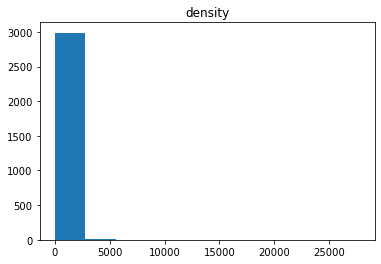

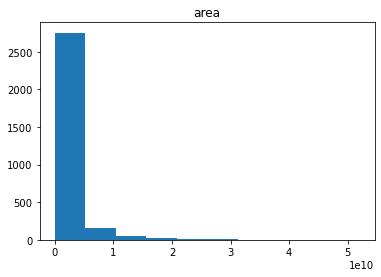

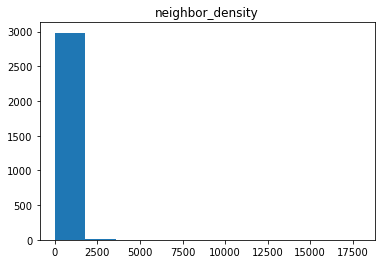

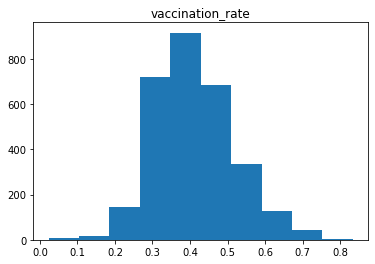

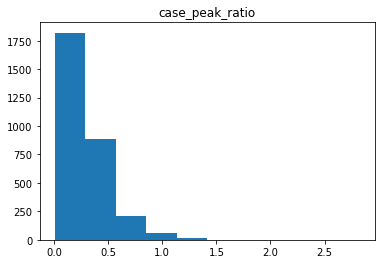

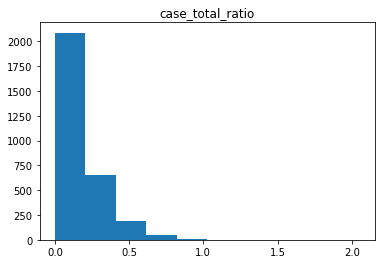

In [13]:
# Inspect feature histograms
for col in counties_features.columns:
    plt.hist(counties_features[col])
    plt.title(col)
    plt.show()
    
# 5 of the 6 features are significantly right skewed.

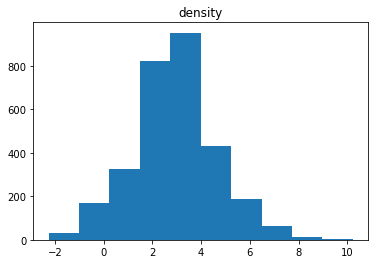

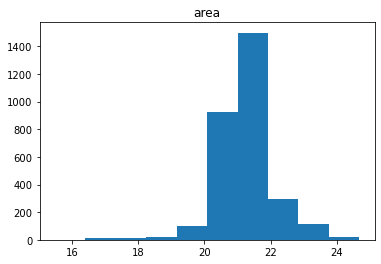

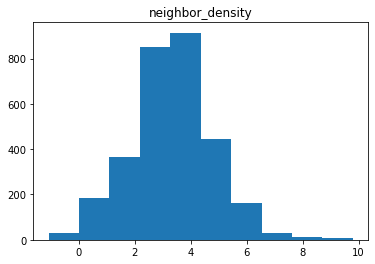

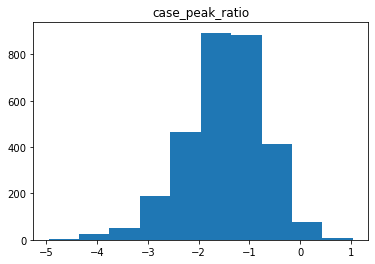

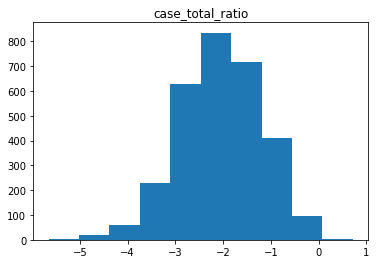

In [14]:
# What do the 5 skewed columns look like under log transformation?
skewed_columns = ['density', 'area', 'neighbor_density', 'case_peak_ratio', 'case_total_ratio']
for col in skewed_columns:
    plt.hist(counties_features[col].map(lambda x: 0 if (x==0) else np.log(x)))
    plt.title(col)
    plt.show()
    
# beautiful

<ipython-input-15-759d71adc54b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties_features[col] = counties_features[col].map(lambda x: 0 if (x==0) else np.log(x))
<ipython-input-15-759d71adc54b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties_features[col] = (counties_features[col] - mean) / std


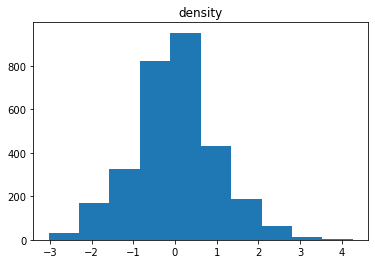

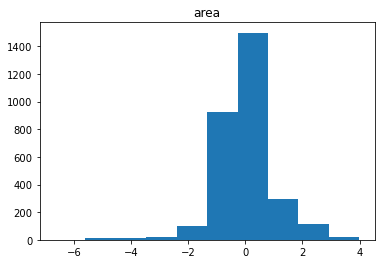

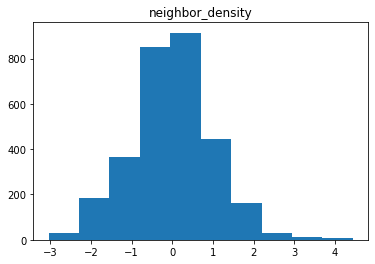

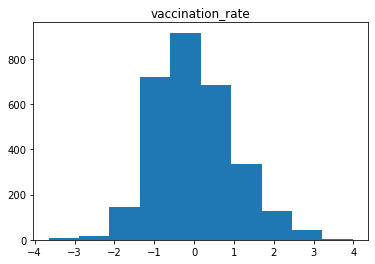

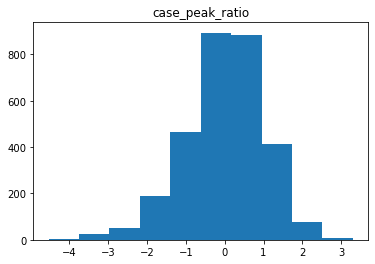

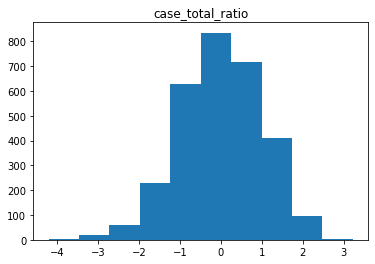

In [15]:
# Execute transformation and normalize
for col in skewed_columns:
    counties_features[col] = counties_features[col].map(lambda x: 0 if (x==0) else np.log(x))
    
for col in counties_features.columns:
    mean = counties_features[col].mean()
    std = counties_features[col].std()
    counties_features[col] = (counties_features[col] - mean) / std
    plt.hist(counties_features[col])
    plt.title(col)
    plt.show()

In [16]:
# Run correlations on all features and label --> case_density
label='case_density'
counties_features.merge(counties[label], left_index=True, right_index=True).corr()

# Some correlation between case_density and vaccination rate and case_peak_ratio
# case_peak_ratio and case_total_ratio seem lock-stepped, as expected, will go with case_peak_ratio

,density,area,neighbor_density,vaccination_rate,case_peak_ratio,case_total_ratio,case_density
density,1.000000,-0.527839,0.801511,0.355248,0.130022,0.292486,-0.035489
area,-0.527839,1.000000,-0.445306,-0.040559,-0.088344,-0.130313,-0.034494
neighbor_density,0.801511,-0.445306,1.000000,0.294702,0.081698,0.269695,-0.131006
vaccination_rate,0.355248,-0.040559,0.294702,1.000000,-0.129086,-0.074556,-0.307789
case_peak_ratio,0.130022,-0.088344,0.081698,-0.129086,1.000000,0.722035,0.332705
case_total_ratio,0.292486,-0.130313,0.269695,-0.074556,0.722035,1.000000,0.287827
case_density,-0.035489,-0.034494,-0.131006,-0.307789,0.332705,0.287827,1.000000


In [17]:
# Maybe indentify the greatest variances in the feature space, PCA
pca = PCA()
pca.fit(counties_features)

print(pca.explained_variance_ratio_)
print(pd.DataFrame(pca.components_.T, index=counties_features.columns))

# The first PCA component is the urban/rural axis, as expected, which I think the models can access readily with original features 
# The second PCA component (accounting for 27% of variance) shows significant spread along the vaccination_rate and inverse case_peak_ratio
# Hmmm, let's also try to predict vaccination _rate... as a separate problem

[0.41843482 0.27316603 0.15102963 0.08538449 0.04140789 0.03057714]
                         0         1         2         3         4         5
density           0.564816 -0.198604 -0.008108 -0.216564 -0.139058 -0.758444
area             -0.405834  0.127875  0.619169 -0.631758 -0.132292 -0.137685
neighbor_density  0.536159 -0.204612 -0.017310 -0.508489 -0.145730  0.624955
vaccination_rate  0.209672 -0.408856  0.741849  0.470559  0.075003  0.107161
case_peak_ratio   0.250462  0.641358  0.173507  0.261894 -0.650755  0.061254
case_total_ratio  0.349459  0.569064  0.189260 -0.073533  0.716112 -0.001094


In [18]:
# But what if we isolate post-vaccination case density?
# Let's just look at case density after Jun 21, 2021, call it postvac_density
candata = pd.read_pickle('../../pickles/CANpickles/candata.pkl')
non_continental_states = ['AK', 'HI', 'MP', 'GU', 'VI', 'PR', 'AS']
candata = candata[~candata['state'].isin(non_continental_states)]
counties_features['postvac_density'] = candata[candata['date']>='2021-06-21'].groupby('fips')['cases_new'].sum() / counties['pop']

<ipython-input-18-bcaee39f841f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties_features['postvac_density'] = candata[candata['date']>='2021-06-21'].groupby('fips')['cases_new'].sum() / counties['pop']


In [19]:
counties_features

,density,area,neighbor_density,vaccination_rate,case_peak_ratio,case_total_ratio,postvac_density
FIPS,,,,,,,
21141,0.008624,-0.178218,0.220357,0.010704,-0.122771,0.413202,0.040477
36081,3.543615,-2.064445,4.285388,2.281000,1.530355,1.156542,0.008419
34017,3.336877,-3.057947,3.836747,1.875927,1.891603,1.011670,0.006615
34019,1.048707,-0.474417,1.819389,1.640419,0.324766,0.162588,0.007172
21147,-0.105559,-0.477217,0.076956,-0.780602,-0.524602,-1.049952,0.032267
...,...,...,...,...,...,...,...
47021,0.597789,-0.876756,1.306484,-0.243644,0.180627,0.411704,0.025008
08014,2.215193,-3.449445,1.227146,2.563610,-0.599454,-0.045422,0.009650
08121,-1.877625,1.582890,0.648062,-1.553068,0.182974,-0.070204,0.003260


In [20]:
# Find correlations with postvac_density. I include case_density just to see the correlations side-by-side
counties_features.merge(counties[label], left_index=True, right_index=True).corr()

,density,area,neighbor_density,vaccination_rate,case_peak_ratio,case_total_ratio,postvac_density,case_density
density,1.000000,-0.527839,0.801511,0.355248,0.130022,0.292486,0.050626,-0.035489
area,-0.527839,1.000000,-0.445306,-0.040559,-0.088344,-0.130313,-0.080769,-0.034494
neighbor_density,0.801511,-0.445306,1.000000,0.294702,0.081698,0.269695,0.030376,-0.131006
vaccination_rate,0.355248,-0.040559,0.294702,1.000000,-0.129086,-0.074556,-0.379579,-0.307789
case_peak_ratio,0.130022,-0.088344,0.081698,-0.129086,1.000000,0.722035,0.269312,0.332705
case_total_ratio,0.292486,-0.130313,0.269695,-0.074556,0.722035,1.000000,0.410139,0.287827
postvac_density,0.050626,-0.080769,0.030376,-0.379579,0.269312,0.410139,1.000000,0.498995
case_density,-0.035489,-0.034494,-0.131006,-0.307789,0.332705,0.287827,0.498995,1.000000


In [21]:
# Let's just look at case density *before* Jun 21, 2021, call it prevac_density
counties_features['prevac_density'] = candata[candata['date']<'2021-06-21'].groupby('fips')['cases_new'].sum() / counties['pop']
counties_features.merge(counties[label], left_index=True, right_index=True).corr()

# Pre-vaccination case density has no correlation with population density. Luckily also no correlation with vaccination rate, as expected. 

<ipython-input-21-b194136a11b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties_features['prevac_density'] = candata[candata['date']<'2021-06-21'].groupby('fips')['cases_new'].sum() / counties['pop']


,density,area,neighbor_density,vaccination_rate,case_peak_ratio,case_total_ratio,postvac_density,prevac_density,case_density
density,1.000000,-0.527839,0.801511,0.355248,0.130022,0.292486,0.050626,-0.082493,-0.035489
area,-0.527839,1.000000,-0.445306,-0.040559,-0.088344,-0.130313,-0.080769,-0.012181,-0.034494
neighbor_density,0.801511,-0.445306,1.000000,0.294702,0.081698,0.269695,0.030376,-0.187606,-0.131006
vaccination_rate,0.355248,-0.040559,0.294702,1.000000,-0.129086,-0.074556,-0.379579,-0.168197,-0.307789
case_peak_ratio,0.130022,-0.088344,0.081698,-0.129086,1.000000,0.722035,0.269312,0.247138,0.332705
case_total_ratio,0.292486,-0.130313,0.269695,-0.074556,0.722035,1.000000,0.410139,0.129540,0.287827
postvac_density,0.050626,-0.080769,0.030376,-0.379579,0.269312,0.410139,1.000000,0.124591,0.498995
prevac_density,-0.082493,-0.012181,-0.187606,-0.168197,0.247138,0.129540,0.124591,1.000000,0.894109
case_density,-0.035489,-0.034494,-0.131006,-0.307789,0.332705,0.287827,0.498995,0.894109,1.000000


## Predict Case Density

In [22]:
# split data into training and testing sets, 67%/33%
case_density_features = ['density', 'area', 'neighbor_density', 'vaccination_rate', 'case_peak_ratio']
case_density_label = 'case_density'
X_train, X_test, y_train, y_test = train_test_split(counties_features[case_density_features], counties[case_density_label], test_size=0.33, random_state=17)

In [23]:
counties[case_density_label].describe()

# Huh, this implies approximately 41% of Americans have been infected?

count    3001.000000
mean        0.123217
std         0.033624
min         0.014560
25%         0.102400
50%         0.124138
75%         0.143244
max         0.466856
Name: case_density, dtype: float64

In [24]:
# Create off-the-shelf models
linearRgr = LinearRegression()
treeRgr = DecisionTreeRegressor(random_state=17)
knnRgr = KNeighborsRegressor()
rndforestRgr = RandomForestRegressor(random_state=17)
svmRgr = SVR()
xgbRgr_OTS = XGBRegressor()

# Through my own series of raw testing (manually adjusting params), I isolated the following param set as optimal for xgboost.
# Default values of several params ended up being optimal.
xgbRgr_manual = XGBRegressor(n_estimators=20, reg_lambda=2., eta=0.3, gamma=0, reg_alpha=0, max_depth=4, subsample=1)

In [25]:
# Run cross_val_score to view quality
print('linear regression:', cross_val_score(linearRgr, X_train, y_train, cv=5).mean())
print('decision tree regression:', cross_val_score(treeRgr, X_train, y_train, cv=5).mean())
print('k nearest neighbors regression:', cross_val_score(knnRgr, X_train, y_train.ravel(), cv=5).mean())
print('random forest regression:', cross_val_score(rndforestRgr, X_train, y_train, cv=5).mean())
print('support vector machine regression:', cross_val_score(svmRgr, X_train, y_train.ravel(), cv=5).mean())
print('xgboost off-the-shelf regression:', cross_val_score(xgbRgr_OTS, X_train, y_train, cv=5).mean())
print('xgboost manually-tuned regression:', cross_val_score(xgbRgr_manual, X_train, y_train, cv=5).mean())

linear regression: 0.18179153717228239
decision tree regression: -0.5515456414348157
k nearest neighbors regression: 0.15104310955540073
random forest regression: 0.18278149387188286
support vector machine regression: -0.48248590059444235
xgboost off-the-shelf regression: 0.06203644956211696
xgboost manually-tuned regression: 0.18707578563723273


In [26]:
# Fit and predict
print('BASELINE naive predictions against mean of training targets:', mean_absolute_error(np.full(y_test.shape[0], y_train.mean()), y_test))
print('linear regression MAE:', mean_absolute_error(linearRgr.fit(X_train, y_train).predict(X_test), y_test))
print('decision tree regression MAE:', mean_absolute_error(treeRgr.fit(X_train, y_train).predict(X_test), y_test))
print('k nearest neighbors regression MAE:', mean_absolute_error(knnRgr.fit(X_train, y_train).predict(X_test), y_test))
print('random forest regression MAE:', mean_absolute_error(rndforestRgr.fit(X_train, y_train).predict(X_test), y_test))
print('support vector regression MAE:', mean_absolute_error(svmRgr.fit(X_train, y_train).predict(X_test), y_test))
print('xgboost off-the-shelf regression MAE:', mean_absolute_error(xgbRgr_OTS.fit(X_train, y_train).predict(X_test), y_test))
print('xgboost manually-tuned regression MAE:', mean_absolute_error(xgbRgr_manual.fit(X_train, y_train).predict(X_test), y_test))

BASELINE naive predictions against mean of training targets: 0.02586951859912746
linear regression MAE: 0.02204921828517618
decision tree regression MAE: 0.02718329294416468
k nearest neighbors regression MAE: 0.022106862316589884
random forest regression MAE: 0.021333856792824932
support vector regression MAE: 0.03144757395822651
xgboost off-the-shelf regression MAE: 0.02266255998028282
xgboost manually-tuned regression MAE: 0.021270861195167915


In [27]:
# Let's see what hyperopt says
def objective(space):
    xgb_hyperopt = XGBRegressor(
        n_estimators = int(space['n_estimators']),
        eta = space['eta'],
        max_depth = int(space['max_depth']),
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        gamma = space['gamma'],
        reg_alpha = space['alpha'],
        reg_lambda = space['lambda']
    )
    
    return {'loss': mean_absolute_error(xgb_hyperopt.fit(X_train, y_train).predict(X_test), y_test), 'status': STATUS_OK}
    

space = {
    'n_estimators': hp.quniform('n_estimators', 5, 200, 5),
    'eta': hp.uniform('eta', 0.05, 0.5),
    'max_depth': hp.quniform('max_depth', 1, 14, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'subsample': hp.uniform('subsample', 0.7, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'alpha' : hp.quniform('alpha', 0, 20, 1),
    'lambda': hp.uniform('lambda', 0, 3),
}

trials = Trials()
best = fmin(objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

best

# Cool, slight imporovement over my best loss from manually tuning of .02127 (passed into xgbRgr_manual above)

100%|████████████████████████████████████████████| 100/100 [00:07<00:00, 13.03trial/s, best loss: 0.022398844952045555]


{'alpha': 0.0,
 'eta': 0.3301844574620725,
 'gamma': 0.02656962586865938,
 'lambda': 0.5053862500845125,
 'max_depth': 3.0,
 'min_child_weight': 10.0,
 'n_estimators': 75.0,
 'subsample': 0.7043296643277126}

## Predict Vaccination Rate

In [28]:
# split data
vaccination_rate_features = ['density', 'area', 'neighbor_density', 'case_peak_ratio']
vaccination_rate_label = 'vaccination_rate'
X_train, X_test, y_train, y_test = train_test_split(counties_features[vaccination_rate_features], counties[vaccination_rate_label], test_size=0.33, random_state=13)

In [29]:
counties[vaccination_rate_label].describe()

count    3001.000000
mean        0.410864
std         0.106154
min         0.023000
25%         0.336000
50%         0.397000
75%         0.476000
max         0.834000
Name: vaccination_rate, dtype: float64

In [30]:
# Create off-the-shelf models
linearRgr = LinearRegression()
treeRgr = DecisionTreeRegressor(random_state=17)
knnRgr = KNeighborsRegressor()
rndforestRgr = RandomForestRegressor(random_state=17)
svmRgr = SVR()
xgbRgr_OTS = XGBRegressor()

In [33]:
# Run cross_val_score to view quality
print('linear regression:', cross_val_score(linearRgr, X_train, y_train, cv=5).mean())
print('decision tree regression:', cross_val_score(treeRgr, X_train, y_train, cv=5).mean())
print('k nearest neighbors regression:', cross_val_score(knnRgr, X_train, y_train.ravel(), cv=5).mean())
print('random forest regression:', cross_val_score(rndforestRgr, X_train, y_train, cv=5).mean())
print('support vector machine regression:', cross_val_score(svmRgr, X_train, y_train.ravel(), cv=5).mean())
print('xgboost regression:', cross_val_score(xgbRgr_OTS, X_train, y_train, cv=5).mean())

linear regression: 0.1758993608381042
decision tree regression: -0.4821097890778595
k nearest neighbors regression: 0.140250298556567
random forest regression: 0.2058407615854289
support vector machine regression: 0.21074936846265407
xgboost regression: 0.08163440505941248


In [34]:
# fit and predict
print('BASELINE naive predictions against mean of training targets:', mean_absolute_error(np.full(y_test.shape[0], y_train.mean()), y_test))
print('linear regression MAE:', mean_absolute_error(linearRgr.fit(X_train, y_train).predict(X_test), y_test))
print('decision tree regression MAE:', mean_absolute_error(treeRgr.fit(X_train, y_train).predict(X_test), y_test))
print('k nearest neighbors regression MAE:', mean_absolute_error(knnRgr.fit(X_train, y_train).predict(X_test), y_test))
print('random forest regression MAE:', mean_absolute_error(rndforestRgr.fit(X_train, y_train).predict(X_test), y_test))
print('support vector regression MAE:', mean_absolute_error(svmRgr.fit(X_train, y_train).predict(X_test), y_test))
print('xgboost off-the-shelf regression MAE:', mean_absolute_error(xgbRgr_OTS.fit(X_train, y_train).predict(X_test), y_test))

BASELINE naive predictions against mean of training targets: 0.08384314200942815
linear regression MAE: 0.07476529222788453
decision tree regression MAE: 0.09875378405650859
k nearest neighbors regression MAE: 0.07619011099899092
random forest regression MAE: 0.07239881937436933
support vector regression MAE: 0.07304859348347685
xgboost off-the-shelf regression MAE: 0.07410624883213392


In [35]:
# Let's check the hyperopt tuning
def objective(space):
    xgb_hyperopt = XGBRegressor(
        n_estimators = int(space['n_estimators']),
        eta = space['eta'],
        max_depth = int(space['max_depth']),
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        gamma = space['gamma'],
        reg_alpha = space['alpha'],
        reg_lambda = space['lambda']
    )
    
    return {'loss': mean_absolute_error(xgb_hyperopt.fit(X_train, y_train).predict(X_test), y_test), 'status': STATUS_OK}
    

space = {
    'n_estimators': hp.quniform('n_estimators', 5, 400, 5),
    'eta': hp.uniform('eta', 0.05, 0.5),
    'max_depth': hp.quniform('max_depth', 1, 14, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'subsample': hp.uniform('subsample', 0.7, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'alpha' : hp.quniform('alpha', 0, 20, 1),
    'lambda': hp.uniform('lambda', 0, 3),
}

trials = Trials()
best = fmin(objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

best

100%|█████████████████████████████████████████████| 100/100 [00:22<00:00,  4.52trial/s, best loss: 0.07072527908749586]


{'alpha': 1.0,
 'eta': 0.10121729068275245,
 'gamma': 0.00790390924863181,
 'lambda': 2.2037998153387064,
 'max_depth': 3.0,
 'min_child_weight': 7.0,
 'n_estimators': 255.0,
 'subsample': 0.8070082014777131}

## Next Steps
- Plot of vaccination rate predictions, baseline predictions, and actual vaccination rates on same axes. X-axis is fips, but ordered by increasing actual vaccination rates.
- Same for case density.
- ...

In [36]:
vaccs = pd.concat([X_test, 
                  pd.Series(XGBRegressor(
                            n_estimators = int(best['n_estimators']),
                            eta = best['eta'],
                            max_depth = int(best['max_depth']),
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            gamma = best['gamma'],
                            reg_alpha = best['alpha'],
                            reg_lambda = best['lambda']
                        ).fit(X_train, y_train).predict(X_test), name='predicts', index=X_test.index),
                  y_test
                 ], axis=1)

In [37]:
vaccs2 = pd.concat([X_test, 
                  pd.Series(XGBRegressor().fit(X_train, y_train).predict(X_test), name='predicts', index=X_test.index),
                  y_test
                 ], axis=1)
vaccs2 = vaccs2.sort_values('vaccination_rate')

In [38]:
vaccs.isna().sum()

density             0
area                0
neighbor_density    0
case_peak_ratio     0
predicts            0
vaccination_rate    0
dtype: int64

In [39]:
vaccs['baseline'] = np.full(y_test.shape[0], y_train.mean())

In [40]:
vaccs.describe()

,density,area,neighbor_density,case_peak_ratio,predicts,vaccination_rate,baseline
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,9.910000e+02
mean,0.048470,-0.016455,0.070122,-0.013967,0.410850,0.416053,4.083050e-01
std,0.990919,0.977586,0.989681,0.988535,0.058251,0.105902,2.832498e-15
min,-2.983492,-6.675450,-3.039883,-3.460294,0.258954,0.024000,4.083050e-01
25%,-0.475908,-0.485234,-0.512468,-0.609573,0.368008,0.340500,4.083050e-01
50%,0.008624,-0.040287,0.063876,0.054884,0.396801,0.401000,4.083050e-01
75%,0.611146,0.409949,0.645115,0.668256,0.444797,0.476000,4.083050e-01
max,3.880742,3.904859,4.443778,2.941752,0.597203,0.787000,4.083050e-01


In [41]:
vaccs = vaccs.sort_values('vaccination_rate')

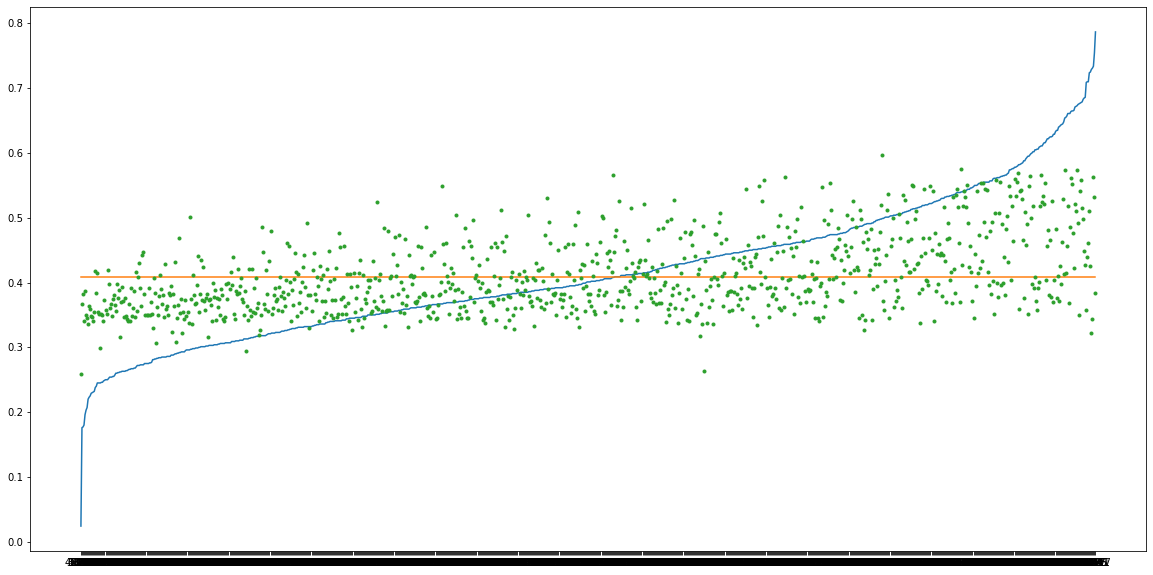

In [42]:
plt.figure(figsize=(20,10))
plt.plot(vaccs['vaccination_rate'])
plt.plot(vaccs['baseline'])
plt.plot(vaccs['predicts'], marker='.', linestyle='None')

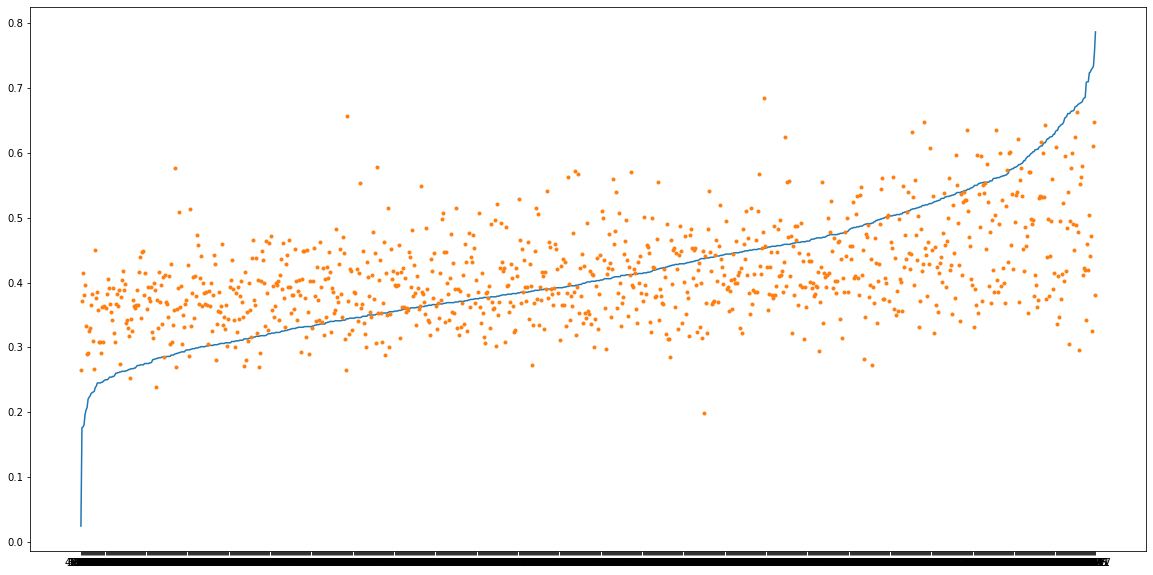

In [43]:
plt.figure(figsize=(20,10))
plt.plot(vaccs2['vaccination_rate'])
plt.plot(vaccs2['predicts'], marker='.', linestyle='None')

# Looking at the hyperopt params vs the off-the-shelf params, we see hyperopt puts an artificial minimum on many values
# Need to look into this later